<a href="https://colab.research.google.com/github/katlynkenisha/Threads/blob/main/Threads%20-%20Review%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
!pip install inflect
!pip install pyspellchecker

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import inflect
import re
from collections import Counter
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/My Drive/Colab Notebooks/threads_reviews.csv'
df = pd.read_csv(file_path)
df.head(5)

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


# **Data Cleaning and Preparation**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [6]:
df['source'].unique()

array(['Google Play', 'App Store'], dtype=object)

In [7]:
df['rating'].unique()

array([2, 3, 1, 5, 4])

# Data Cleaning and Preparation for Platform



In [8]:
# Separate each platform into corresponding dataframes
df_android = df[df['source'] == 'Google Play']
df_ios = df[df['source'] == 'App Store']

# Data Cleaning and Preparation for Reviews

In [9]:
# Modify words in reviews to lowercase
df['review_description'] = df['review_description'].str.lower()

In [10]:
# Change specific typos
df['review_description'] = df['review_description'].str.replace(r'\baap\b', 'application')
df['review_description'] = df['review_description'].str.replace(r'\bappp\b', 'application')
df['review_description'] = df['review_description'].str.replace(r'\bcompitition\b', 'competition')
df['review_description'] = df['review_description'].str.replace(r'\bsoo\b', 'so')
df['review_description'] = df['review_description'].str.replace(r'\bsoooo\b', 'so')
df['review_description'] = df['review_description'].str.replace(r'\btweeter\b', 'twitter')
df['review_description'] = df['review_description'].str.replace(r'\btwiter\b', 'twitter')
df['review_description'] = df['review_description'].str.replace(r'\btwitters\b', 'twitter')

We will create a new variable called review_list to store the reviews in the form of list of words. This is done to avoid modifying the words contained in the original reviews.

In [11]:
# Split sentences into list of words in a new variable called review_list
def split_sentence_into_words(sentence):
    return sentence.split()

df['review_list'] = df['review_description'].apply(split_sentence_into_words)

In [12]:
# Remove non-alphabet characters from list of words
def remove_non_text_characters(word_list):
    return [re.sub(r'[^a-zA-Z]', '', word) for word in word_list]

df['review_list'] = df['review_list'].apply(remove_non_text_characters)

In [13]:
# Remove spaces from list of words
df['review_list'] = df['review_list'].apply(lambda words: [word.replace(' ', '') for word in words])

In [14]:
# Remove stopwords from list of words
stop_words = set(stopwords.words('english'))

df['review_list'] = df['review_list'].apply(lambda sublist: [word for word in sublist if word.lower() not in stop_words])

In [15]:
# Lemmatize words
lemmatizer = WordNetLemmatizer()

def lemmatize_word_list(word_list):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_list]
    return lemmatized_words

df['review_list'] = df['review_list'].apply(lemmatize_word_list)

In [16]:
# Change specific words / synonyms
df['review_list'] = df['review_list'].apply(lambda word_list: [re.sub(r'\bapp(s)?\b', 'application', word) for word in word_list])
df['review_list'] = df['review_list'].apply(lambda word_list: [re.sub(r'\bcopied\b', 'copy', word) for word in word_list])
df['review_list'] = df['review_list'].apply(lambda word_list: [re.sub(r'\bcopying\b', 'copy', word) for word in word_list])
df['review_list'] = df['review_list'].apply(lambda word_list: [re.sub(r'\bimitation\b', 'copy', word) for word in word_list])

# Data Cleaning and Preparation for Rating

Ratings will be classified into:
*   1 and 2 = Negative
*   3 = Neutral
*   4 and 5 = Positive

In [17]:
# Separate each ratings into corresponding dataframes
df_negative = df[(df['rating'] == 1) | (df['rating'] == 2)]
df_neutral = df[(df['rating'] == 3)]
df_positive = df[(df['rating'] == 4) | (df['rating'] == 5)]

# Data Cleaning and Preparation for Review Date

In [18]:
# Keep date only without using time for reviews
df['review_date'] = df['review_date'].str.split(' ').str[0]

In [19]:
# Check date range of reviews
df['review_date'].agg(['min', 'max'])

min    2023-07-05
max    2023-07-25
Name: review_date, dtype: object

In [20]:
# Convert into datetime
df['review_date'] = pd.to_datetime(df['review_date'])

# Data Exploration

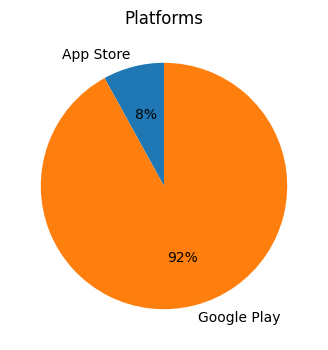

In [21]:
# Display platforms
counts = df['source'].value_counts()
counts = counts.sort_index()

plt.figure(figsize=(4, 4))
plt.pie(counts.values, labels=counts.index, autopct='%1.0f%%', startangle=90)
plt.title('Platforms')
plt.show()

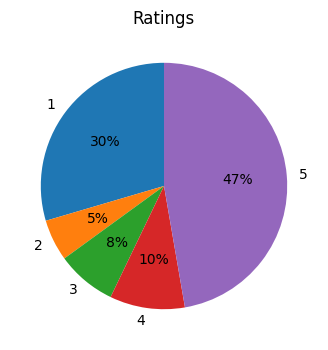

In [22]:
# Display ratings
counts = df['rating'].value_counts()
counts = counts.sort_index()

plt.figure(figsize=(4, 4))
plt.pie(counts.values, labels=counts.index, autopct='%1.0f%%', startangle=90)
plt.title('Ratings')
plt.show()

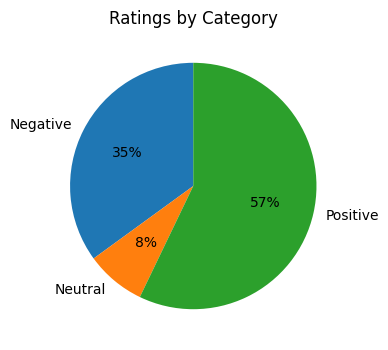

In [23]:
# Display categorized ratings
count_negative = len(df_negative)
count_neutral = len(df_neutral)
count_positive = len(df_positive)

categories = ['Negative', 'Neutral', 'Positive']
counts = [count_negative, count_neutral, count_positive]

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)
plt.title('Ratings by Category')
plt.show()

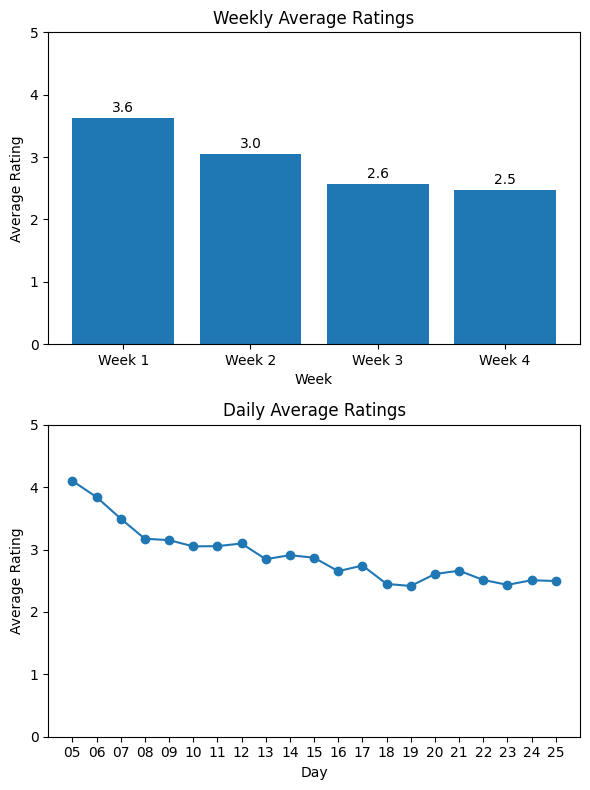

In [24]:
# Display average ratings based on weekly timeframe
average_ratings_per_week = df.groupby(df['review_date'].dt.to_period('W-SAT'))['rating'].mean()
average_ratings_per_week.index = range(1, len(average_ratings_per_week) + 1)

# Display average ratings based on daily timeframe
average_ratings_per_day = df.groupby(df['review_date'].dt.to_period('D'))['rating'].mean()
date_strings = average_ratings_per_day.index.to_timestamp().strftime('%d')

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

axs[0].bar(average_ratings_per_week.index, average_ratings_per_week.values)
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Average Rating')
axs[0].set_title('Weekly Average Ratings')
axs[0].set_xticks(average_ratings_per_week.index)
axs[0].set_xticklabels([f'Week {i}' for i in average_ratings_per_week.index], rotation=0)
for i, value in enumerate(average_ratings_per_week.values):
    axs[0].text(i + 1, value + 0.05, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
axs[0].set_yticks(range(6))

axs[1].plot(range(1, len(date_strings) + 1), average_ratings_per_day.values, marker='o')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Average Rating')
axs[1].set_title('Daily Average Ratings')
axs[1].set_xticks(range(1, len(date_strings)+1))
axs[1].set_xticklabels(date_strings, rotation=0)
axs[1].set_yticks(range(6))

plt.tight_layout()
plt.show()

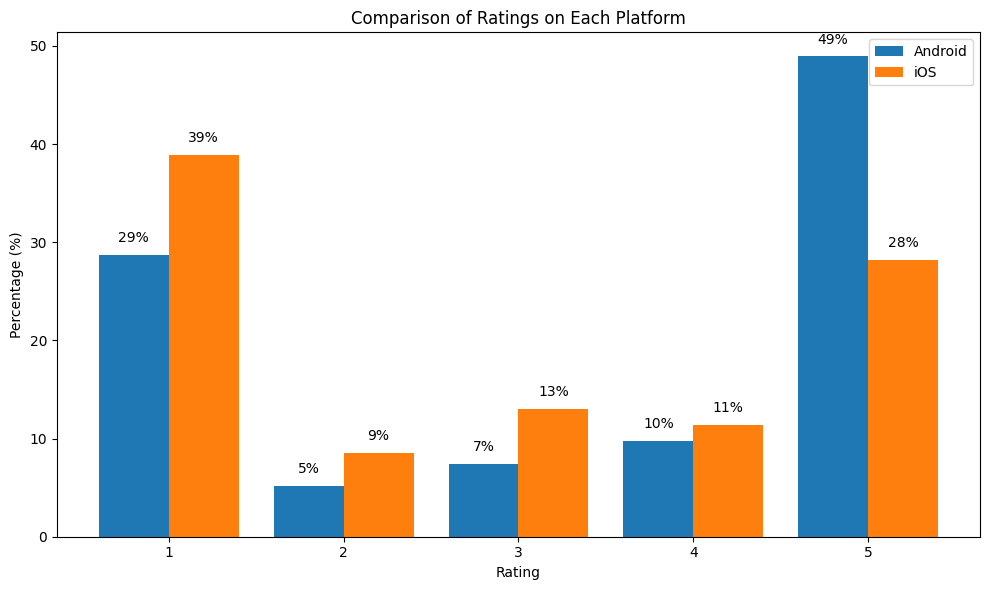

In [25]:
# Display ratings based on platform
android_rating_counts = df_android['rating'].value_counts()
android_total_ratings = len(df_android)
android_rating_percentages = (android_rating_counts / android_total_ratings) * 100

ios_rating_counts = df_ios['rating'].value_counts()
ios_total_ratings = len(df_ios)
ios_rating_percentages = (ios_rating_counts / ios_total_ratings) * 100

all_ratings = np.union1d(android_rating_percentages.index, ios_rating_percentages.index)

rating_data = pd.DataFrame({
    'Android': android_rating_percentages.reindex(all_ratings, fill_value=0),
    'iOS': ios_rating_percentages.reindex(all_ratings, fill_value=0)
})

# Compare percentages
plt.figure(figsize=(10, 6))
bar_width = 0.4

bar_positions_android = np.arange(len(rating_data))
bar_positions_ios = bar_positions_android + bar_width

plt.bar(bar_positions_android, rating_data['Android'], width=bar_width, label='Android')
plt.bar(bar_positions_ios, rating_data['iOS'], width=bar_width, label='iOS')

for x_pos, percentage in zip(bar_positions_android, rating_data['Android']):
    plt.text(x_pos, percentage + 1, f"{percentage:.0f}%", ha='center', va='bottom')

for x_pos, percentage in zip(bar_positions_ios, rating_data['iOS']):
    plt.text(x_pos, percentage + 1, f"{percentage:.0f}%", ha='center', va='bottom')

plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Ratings on Each Platform')
plt.xticks(bar_positions_android + bar_width / 2, all_ratings)
plt.legend()

plt.tight_layout()
plt.show()

# Analyzing main opinions based on positive, neutral, and negative reviews

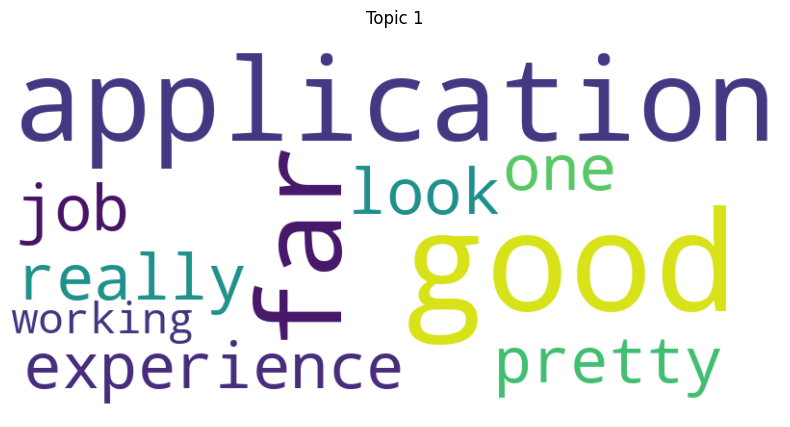

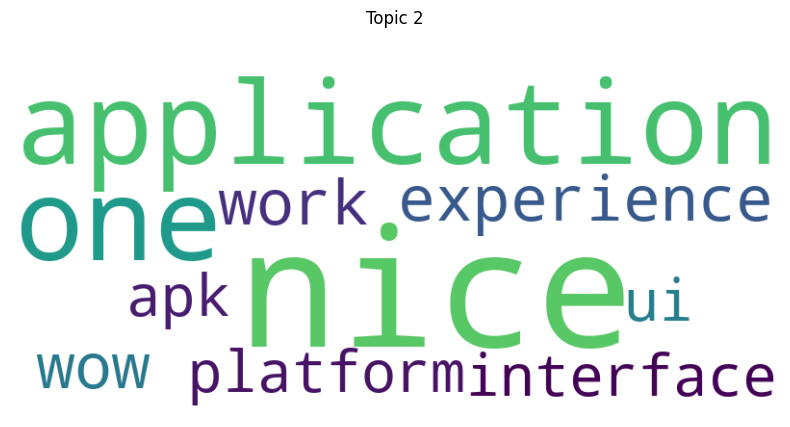

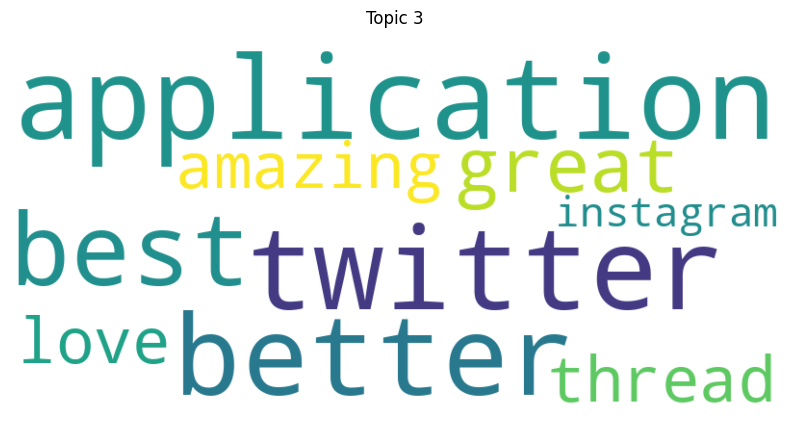

In [26]:
# Analyze main opinions for positive reviews
documents = df_positive['review_list'].apply(lambda review: ' '.join(review))
num_features = 5000
vectorizer = TfidfVectorizer(max_features=num_features)
tfidf_matrix = vectorizer.fit_transform(documents)

num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics.append(top_words)

for topic_idx, topic in enumerate(topics):
    topic_text = ' '.join(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_idx + 1}')
    plt.axis('off')
    plt.show()

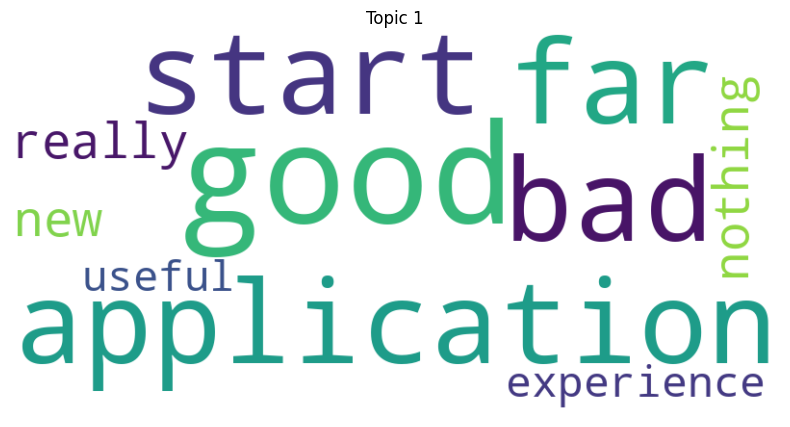

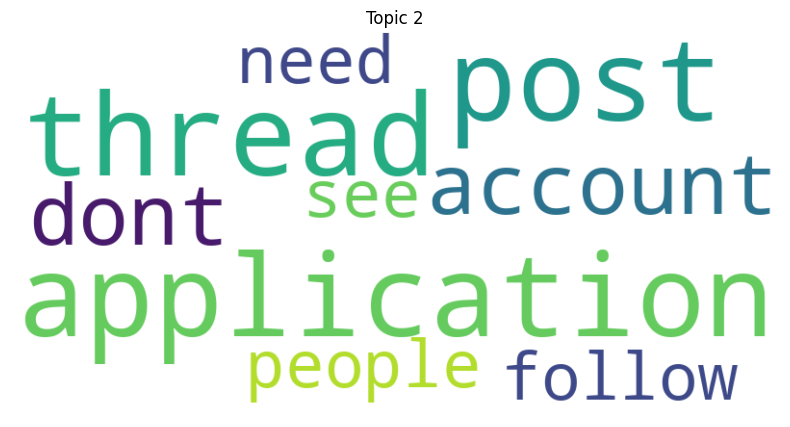

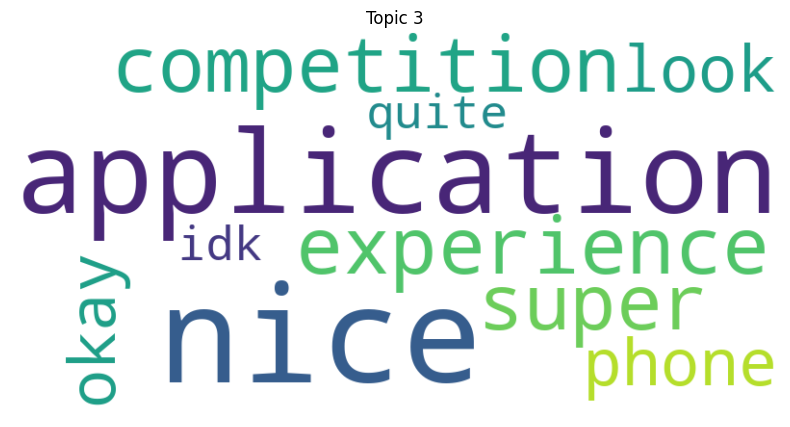

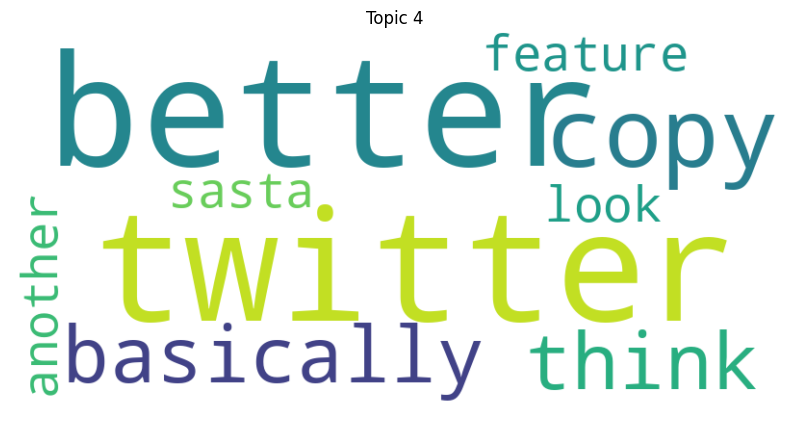

In [27]:
# Analyze main opinions for neutral reviews
documents = df_neutral['review_list'].apply(lambda review: ' '.join(review))
num_features = 5000
vectorizer = TfidfVectorizer(max_features=num_features)
tfidf_matrix = vectorizer.fit_transform(documents)

num_topics = 4
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics.append(top_words)

for topic_idx, topic in enumerate(topics):
    topic_text = ' '.join(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_idx + 1}')
    plt.axis('off')
    plt.show()

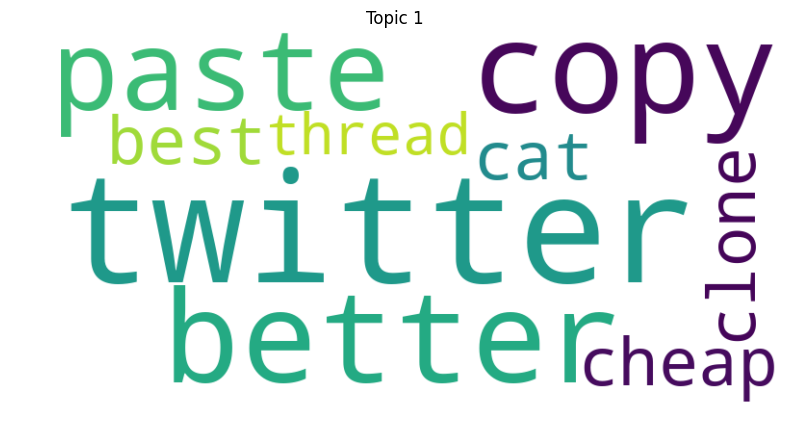

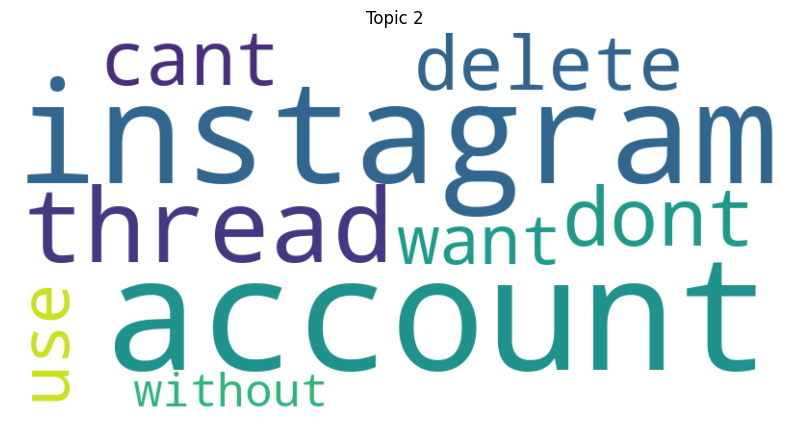

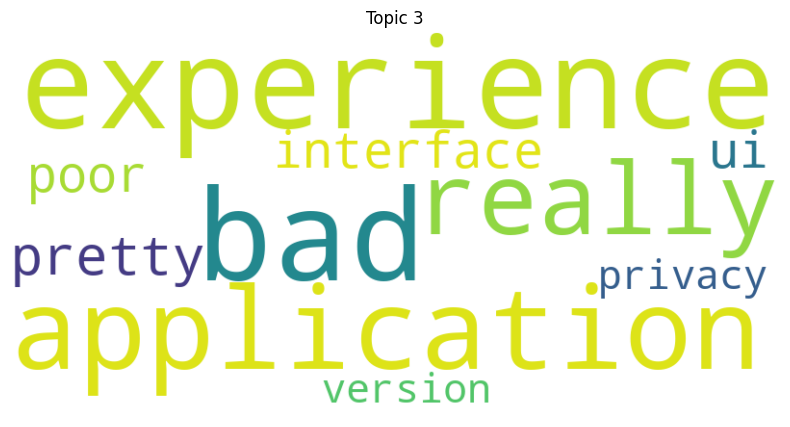

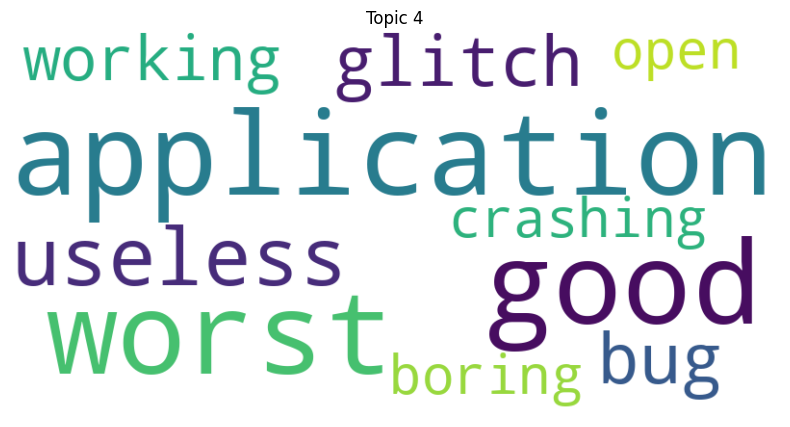

In [28]:
# Analyze main opinions for negative reviews
documents = df_negative['review_list'].apply(lambda review: ' '.join(review))
num_features = 5000
vectorizer = TfidfVectorizer(max_features=num_features)
tfidf_matrix = vectorizer.fit_transform(documents)

num_topics = 4
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics.append(top_words)

for topic_idx, topic in enumerate(topics):
    topic_text = ' '.join(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_idx + 1}')
    plt.axis('off')
    plt.show()

# Analyzing problems faced by users

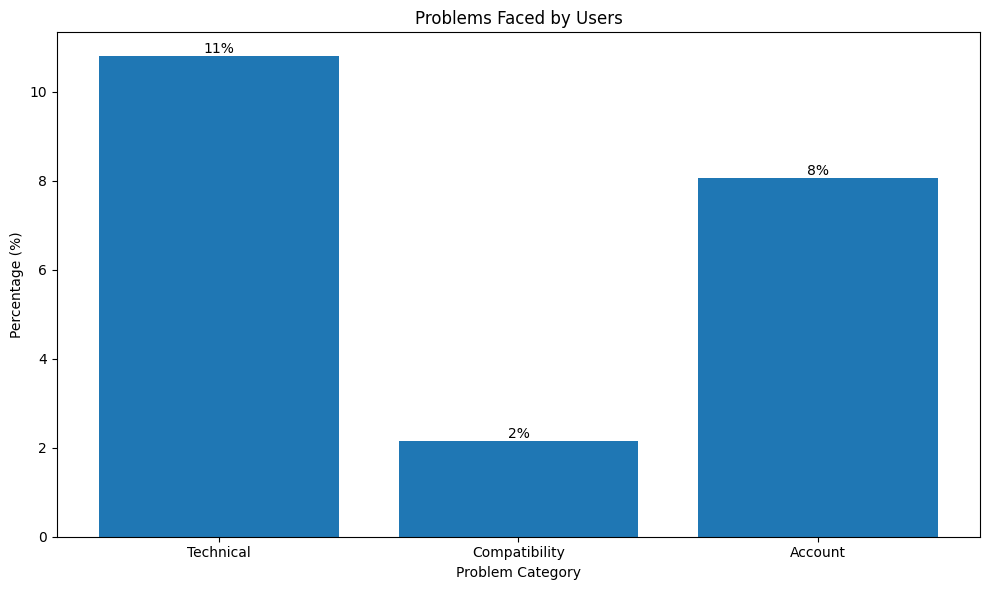

In [30]:
# Specify problem categories to be analyzed based on keywords
technical = ['bugs', 'glitch', 'crash', 'freeze', 'stop', 'lag', 'slow', 'loading', 'error']
compatibility = ['screen size', 'device', 'interface', 'ui']
account = ['sign', 'signing', 'login', 'ing', 'create', 'register', 'password', 'recovery', 'authentloggication']

# Find related words and their inflections
def get_related_words(keyword):
    inflected_keywords = set()
    lemmatizer = WordNetLemmatizer()
    p = inflect.engine()
    inflected_keywords.add(keyword)
    synsets = wordnet.synsets(keyword)
    for synset in synsets:
        for lemma in synset.lemmas():
            inflected_keywords.add(lemma.name())
            inflected_keywords.add(p.plural(lemma.name()))  # Get plural form
            inflected_keywords.add(p.present_participle(lemma.name()))  # Get present participle form
            if synset.pos() == 'v':  # Get past tense form if word is a verb
                inflected_keywords.add(lemmatizer.lemmatize(lemma.name(), wordnet.VERB))

    return inflected_keywords

# Get related words for each main keyword
technical_related_words = set()
for keyword in technical:
    technical_related_words.update(get_related_words(keyword))

compatibility_related_words = set()
for keyword in compatibility:
    compatibility_related_words.update(get_related_words(keyword))

account_related_words = set()
for keyword in account:
    account_related_words.update(get_related_words(keyword))

# Combine keywords
technical_str_check = r'\b(?:' + '|'.join(technical_related_words) + r')\b'
compatibility_str_check = r'\b(?:' + '|'.join(compatibility_related_words) + r')\b'
account_str_check = r'\b(?:' + '|'.join(account_related_words) + r')\b'

# Calculate count and percentage for each problem category
technical_count = df['review_description'].str.contains(technical_str_check, case=False).sum()
compatibility_count = df['review_description'].str.contains(compatibility_str_check, case=False).sum()
account_count = df['review_description'].str.contains(account_str_check, case=False).sum()

total_records = len(df)

technical_percentage = (technical_count / total_records) * 100
compatibility_percentage = (compatibility_count / total_records) * 100
account_percentage = (account_count / total_records) * 100

problem_categories = ['Technical', 'Compatibility', 'Account']
percentages = [technical_percentage, compatibility_percentage, account_percentage]

# Compare percentages
plt.figure(figsize=(10, 6))

bar_positions = list(range(len(problem_categories)))

plt.bar(bar_positions, percentages)
for x, y in zip(bar_positions, percentages):
    plt.text(x, y, f'{y:.0f}%', ha='center', va='bottom')

plt.xlabel('Problem Category')
plt.ylabel('Percentage (%)')
plt.title('Problems Faced by Users')
plt.xticks(bar_positions, problem_categories)
plt.tight_layout()
plt.show()

# Identifying suggestions from users

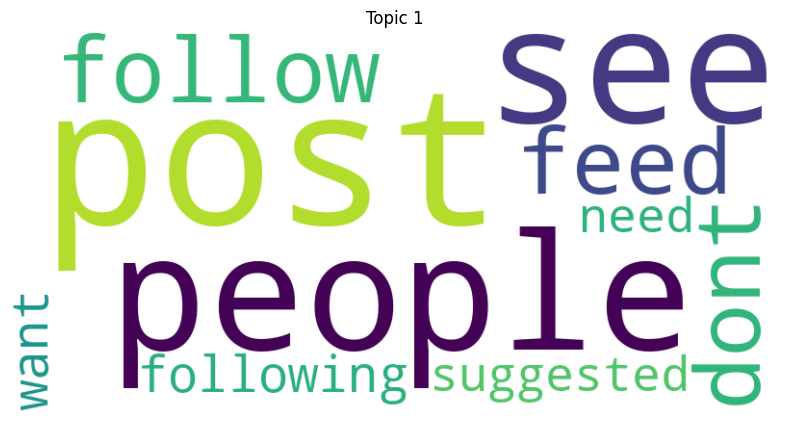

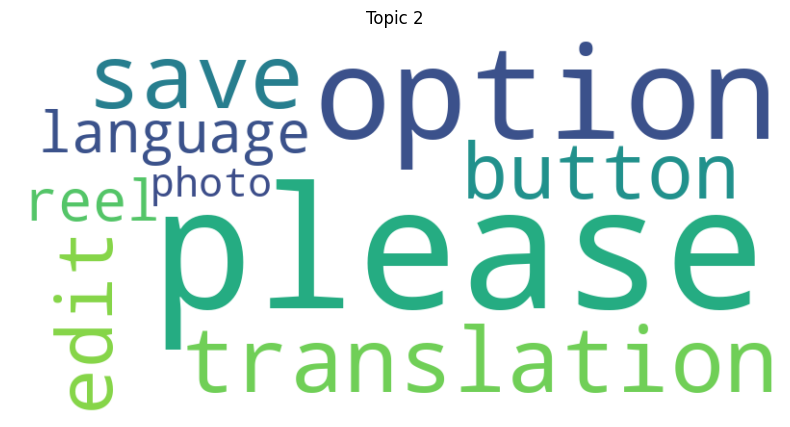

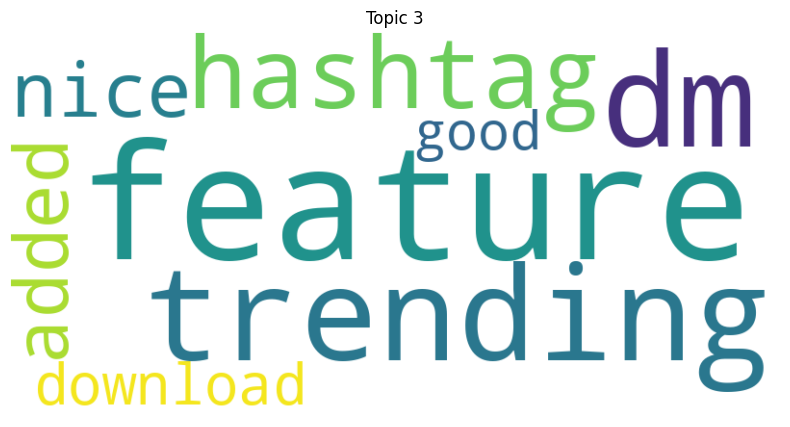

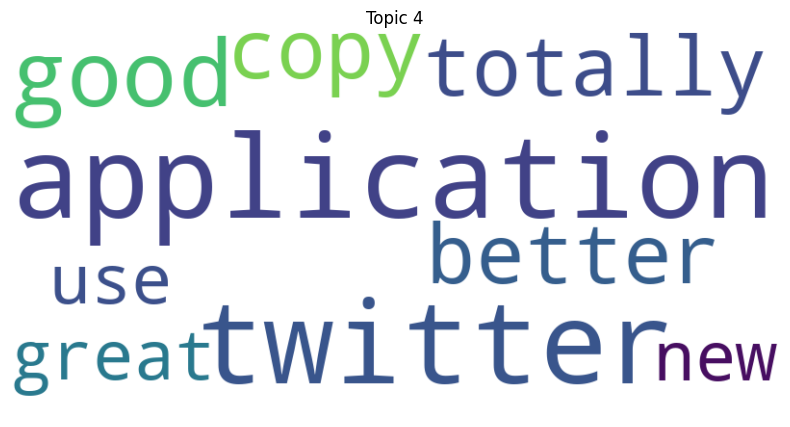

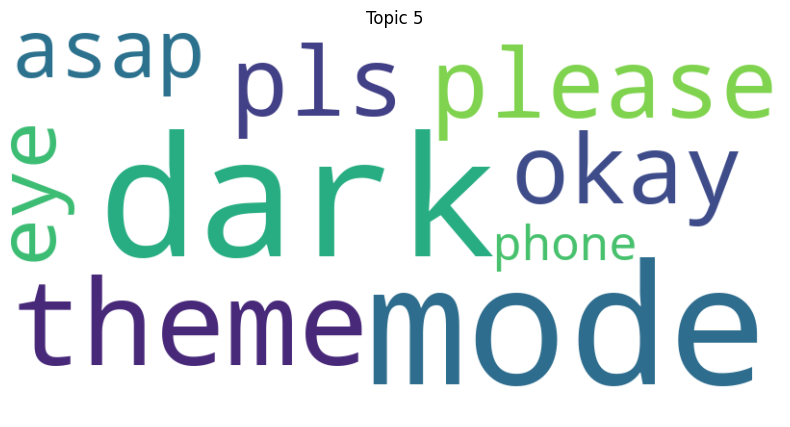

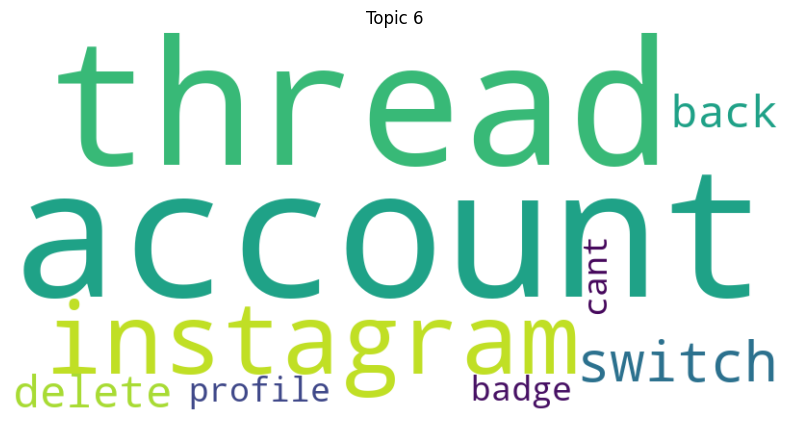

In [31]:
# Specify main keywords
main_keywords = ['add', 'suggest']

# Find related words and their inflections
def get_related_words(keyword):
    inflected_keywords = set()
    lemmatizer = WordNetLemmatizer()
    p = inflect.engine()
    inflected_keywords.add(keyword)
    synsets = wordnet.synsets(keyword)
    for synset in synsets:
        for lemma in synset.lemmas():
            inflected_keywords.add(lemma.name())
            inflected_keywords.add(p.plural(lemma.name())) # Get plural form
            inflected_keywords.add(p.present_participle(lemma.name()))  # Get present participle form
            if synset.pos() == 'v':  # Get past tense form if word is a verb
                inflected_keywords.add(lemmatizer.lemmatize(lemma.name(), wordnet.VERB))

    return inflected_keywords

# Get related words for each main keyword
related_words_dict = {}
for keyword in main_keywords:
    related_words = get_related_words(keyword)
    related_words_dict[keyword] = related_words

# Combine keywords
str_check = r'\b(?:' + '|'.join('|'.join(related_words_dict[keyword]) for keyword in main_keywords) + r')\b'

def identify_keywords(review_text):
    for keyword_set in related_words_dict.values():
        for keyword in keyword_set:
            if re.search(keyword, review_text, re.IGNORECASE):
                return True
    return False

df_keywords = df[df['review_description'].apply(identify_keywords)]

# Analyze suggestions topics based on keywords
documents = df_keywords['review_list'].apply(lambda review: ' '.join(review))
num_features = 5000
vectorizer = TfidfVectorizer(max_features=num_features)
tfidf_matrix = vectorizer.fit_transform(documents)

num_topics = 6
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]

    # Filter out keywords from the wordcloud
    filtered_topic = [word for word in top_words if word not in main_keywords]
    topics.append(filtered_topic)

for topic_idx, topic in enumerate(topics):
    filtered_topic_text = ' '.join(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_idx + 1}')
    plt.axis('off')
    plt.show()

# Check specific reviews using keywords (optional)

In [32]:
keywords = ['switch']

str_check = r'(?=.*{})'.format('.*'.join(keywords)) #and
#str_check = '|'.join(keywords) #or

pd.set_option('display.max_colwidth', None)
check_reviews = df[df['review_description'].str.contains(str_check, case=False, regex=True)]
check_reviews.head(10)

,source,review_description,rating,review_date,review_list
2,Google Play,"for a brand new app, it's very well optimized. however it's just missing quite a few features that apps like twitter have. there is no way to have your timeline show threads from who you're following. it would also be nice to be able to switch accounts quickly like on insta. i've also noticed that videos have a hard time playing audio sometimes. overall, it's a decent first version that i hope will get more features as time goes on. i'll up my rating once the things i mentioned are addressed.",3,2023-07-06,"[brand, new, application, well, optimized, however, missing, quite, feature, application, like, twitter, way, timeline, show, thread, youre, following, would, also, nice, able, switch, account, quickly, like, insta, ive, also, noticed, video, hard, time, playing, audio, sometimes, overall, decent, first, version, hope, get, feature, time, go, ill, rating, thing, mentioned, addressed]"
13,Google Play,"not quite ready for prime time. needs a feed specifically for accounts you follow. if you have more than one instagram account, threads doesn't allow easy switching between accounts without involving logging out/logging in/security confirmation. this shouldn't need to be repeated over and over. also, it is concerning that the app is blocked in the eu due to privacy violations. use at your own risk.",2,2023-07-06,"[quite, ready, prime, time, need, feed, specifically, account, follow, one, instagram, account, thread, doesnt, allow, easy, switching, account, without, involving, logging, outlogging, insecurity, confirmation, shouldnt, need, repeated, also, concerning, application, blocked, eu, due, privacy, violation, use, risk]"
14,Google Play,"very frustrating experience. feed it's full of users i don't follow and don't care for their content. switching between my company and private accounts forces you to complete sign out and reverify. picture upload quality is compressed, twitter images are much sharper. i am hopeful for this app, but it should have never been released as a finished product in it's current state.",2,2023-07-08,"[frustrating, experience, feed, full, user, dont, follow, dont, care, content, switching, company, private, account, force, complete, sign, reverify, picture, upload, quality, compressed, twitter, image, much, sharper, hopeful, application, never, released, finished, product, current, state]"
34,Google Play,"i think it is great but some features needs to be advanced. first the photo loading time is still slow, secondly i suggest that all meta apps could be synced inform of tab/browser where you can switch platforms easly. for example if you are in threads you can have switcheable icons or tabs to navigate to instagram, facebook, whatsapp and vice versa. fourthly, there should be filters through which people could determine thematic areas of interest including themes, topics, personalities, etc",3,2023-07-09,"[think, great, feature, need, advanced, first, photo, loading, time, still, slow, secondly, suggest, meta, application, could, synced, inform, tabbrowser, switch, platform, easly, example, thread, switcheable, icon, tab, navigate, instagram, facebook, whatsapp, vice, versa, fourthly, filter, people, could, determine, thematic, area, interest, including, theme, topic, personality, etc]"
78,Google Play,"it's pretty much facebook's version of twitter. unfortunately the app is unstable and lacks basic features find in its parents app, like switching accounts. whenever i open ""threads"" (replies to a post within the app) the app will crash every other time. it's quite embarrassing to have the main feature bugged. the app is an unoriginal idea and it needs significant improvements. if it worked, could sort feed, switch accounts, and post audio, i'd give 4⭐ i'm using oxygen os 13.1 (oneplus 10 pro)",2,2023-07-07,"[pretty, much, facebooks, version, twitter, unfortunately, application, unstable, lack, basic, feature, find, parent, appl